### This notebook solves a problem of classifing news into 41 catgories. Accuracy till now 70% on validation set.

In [1]:
import re
import string
import unicodedata
import html

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet

from keras.preprocessing.text import text_to_word_sequence, Tokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
np.random.seed(42)
plt.rcParams['figure.figsize'] = (24, 12)

stop_words = set(stopwords.words('english'))

## Load Dataset

In [3]:
df = pd.read_json('Dataset.json', lines=True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [5]:
df.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,category,headline,authors,link,short_description,date
count,200853,200853,200853,200853,200853,200853
unique,41,199344,27993,200812,178353,2309
top,POLITICS,Sunday Roundup,,https://www.huffingtonpost.comhttp://stylelike...,,2013-04-24 00:00:00
freq,32739,90,36620,2,19712,100
first,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2018-05-26 00:00:00


## EDA

In [6]:
# No Nulls
# Check duplicates:
df.loc[df.duplicated(), :]

,category,headline,authors,link,short_description,date
59003,POLITICS,"On Facebook, Trump's Longtime Butler Calls For...",,https://www.huffingtonpost.comhttp://www.mothe...,"Anthony Senecal, who worked as Donald Trump's ...",2016-05-12
59249,TECH,Former Facebook Workers: We Routinely Suppress...,,https://www.huffingtonpost.comhttp://gizmodo.c...,Facebook workers routinely suppressed news sto...,2016-05-09
61565,WOMEN,"On Equal Pay Day, The Gap Is Still Too Wide",,https://www.huffingtonpost.comhttp://www.cnbc....,Equal Pay Day falls on April 12 in 2016. It's ...,2016-04-12
131156,WELLNESS,The World's Most Dangerous Workout?,,https://www.huffingtonpost.comhttp://www.cnn.c...,"Is the ""sport of fitness"" the world's most dan...",2014-02-10
135735,WELLNESS,Some People Call It 'The Best Anti-Smoking Ad ...,,https://www.huffingtonpost.comhttp://www.upwor...,Almost all smokers know cigarettes are bad for...,2013-12-22
136468,ENVIRONMENT,10 Cities That Could Run Out Of Water - Weathe...,,https://www.huffingtonpost.comhttp://www.weath...,"Securing access to plentiful, renewable source...",2013-12-15
169481,TECH,Google Is Attacking Apple From The Inside Out ...,,https://www.huffingtonpost.comhttp://www.busin...,After years of hammering away at Apple's share...,2013-01-01
178655,WELLNESS,"Eating For Health, Not Weight",,https://www.huffingtonpost.comhttp://www.nytim...,Almost half of Americans are on a diet -- not ...,2012-09-23
185922,TECH,Apple Removes Green EPEAT Electronics Certific...,,https://www.huffingtonpost.comhttp://blogs.wsj...,Apple has pulled its products off the U.S. gov...,2012-07-07
185924,TECH,Microsoft's $6.2 Billion Writedown Shows It's ...,,https://www.huffingtonpost.comhttp://www.theda...,Fighting for online advertising dominance with...,2012-07-07


In [7]:
df = df.drop_duplicates()
df.info()

df.loc[df.duplicated(), :]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200840 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200840 non-null  object        
 1   headline           200840 non-null  object        
 2   authors            200840 non-null  object        
 3   link               200840 non-null  object        
 4   short_description  200840 non-null  object        
 5   date               200840 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 10.7+ MB


,category,headline,authors,link,short_description,date


(array([25099., 43425., 22310., 17336.,  5455., 10170., 13852., 23313.,
        25944., 13936.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <a list of 10 Patch objects>)

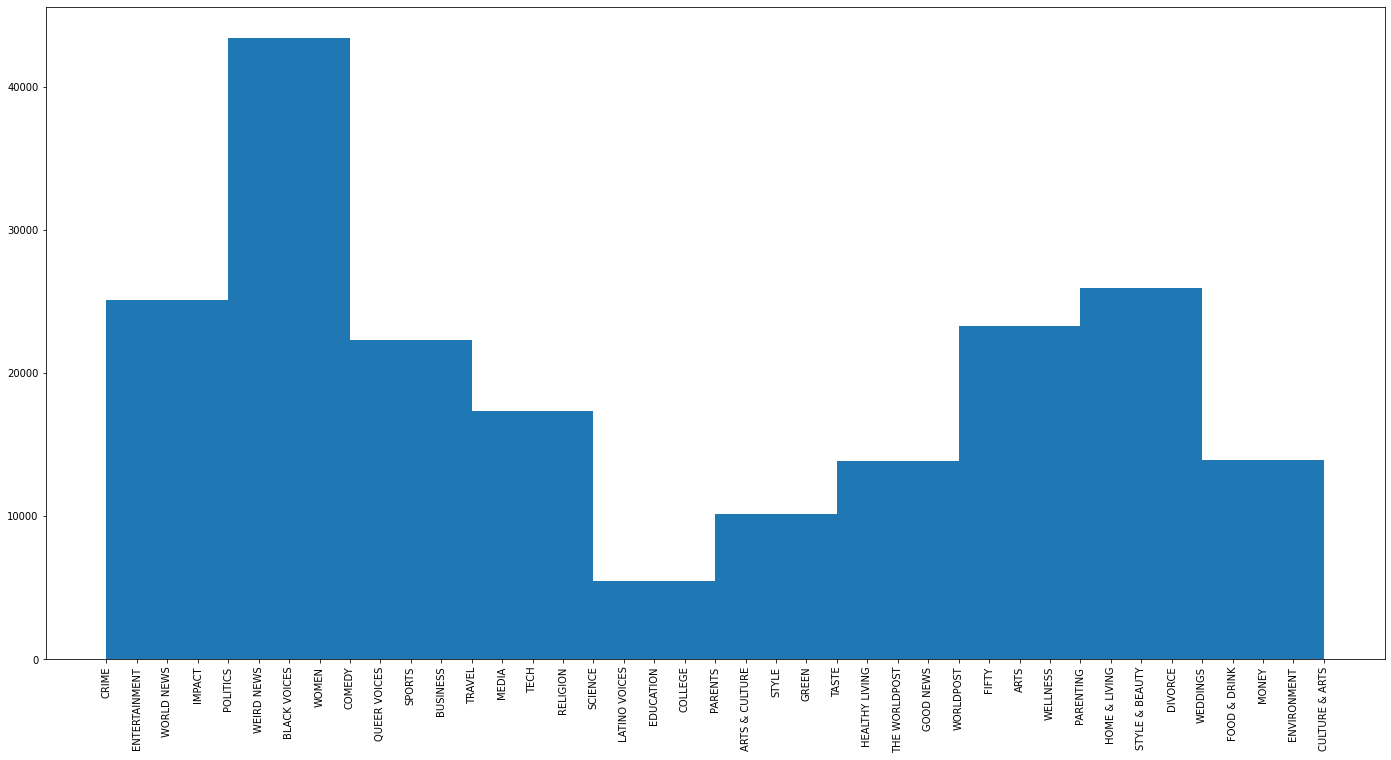

In [8]:
# Show categories distribution
# df.groupby('category').count()
plt.xticks(rotation=90)
plt.hist(df['category'])

## Cleaning & Preprocessing

In [9]:
df.sample(20)
# Noticed empty strings

,category,headline,authors,link,short_description,date
146907,WELLNESS,Do the Best Work of Your Life or Get Your $#*!...,"Ryan McKeever, Contributor\nMarketer, Consulta...",https://www.huffingtonpost.com/entry/do-your-b...,"While something was off for a long time, it wa...",2013-08-27
87022,ENTERTAINMENT,Q&A With Halfway Producer Jonny Paterson on th...,"Pam Stucky, ContributorAuthor, traveler, story...",https://www.huffingtonpost.com/entry/post_9579...,"The truth is, coming from a wee country like S...",2015-06-29
112497,TASTE,10 School Lunches That Totally Trump Sandwiches,Miranda Langrehr,https://www.huffingtonpost.com/entry/school-lu...,,2014-09-08
25253,HEALTHY LIVING,How To Replace Your Self-Doubt With Unshakeabl...,"Elle Kaplan, ContributorCEO and Founder of Lex...",https://www.huffingtonpost.com/entry/how-to-re...,A guide from Harvard Psychologist and TED Talk...,2017-05-31
87548,POLITICS,Protesters Rally Against Confederate Flag At S...,Chris McGonigal,https://www.huffingtonpost.com/entry/confedera...,,2015-06-23
39998,POLITICS,Tillerson's Ties To Russia Leave Lawmakers Uneasy,"Steve Holland, Reuters",https://www.huffingtonpost.com/entry/tillerson...,"""It's very well known that he has a very close...",2016-12-13
180262,WEDDINGS,Couple Rescued From Lake Huron After Marriage ...,,https://www.huffingtonpost.com/entry/couple-re...,"A Detroit, Mich. couple's private marriage pro...",2012-09-06
160699,HOME & LIVING,Master Spring Cleaning With These Surprising Tips,"Laura McHolm, Contributor\nNorthStar Moving Co...",https://www.huffingtonpost.com/entry/spring-cl...,Do you have a home story idea or tip? Email us...,2013-04-03
154045,STYLE & BEAUTY,The New Closet Edit for Global Warming,"Christine Bronstein, Contributor\nFounder of N...",https://www.huffingtonpost.com/entry/the-new-c...,We think the best way to save money on clothes...,2013-06-12
178914,TRAVEL,Geneva's Top Hotels (PHOTOS),"Oyster.com, Contributor\nThe Hotel Tell-All",https://www.huffingtonpost.com/entry/geneva-ho...,Many travelers overlook elegant Geneva when pl...,2012-09-21


In [10]:
df.loc[102956,:]

category                                                      POLITICS
headline                                      Full Speed Ahead For CIA
authors                                                               
link                 https://www.huffingtonpost.com/entry/after-scr...
short_description                                                     
date                                               2014-12-27 00:00:00
Name: 102956, dtype: object

In [11]:
# Check how many non-empty values for each string column
for col in df.columns:
  if df[col].dtype == 'object':
    print(f'Col({col}): Non empty values count =', len(df[df[col].str.strip().str.len() > 0]))


Col(category): Non empty values count = 200840
Col(headline): Non empty values count = 200834
Col(authors): Non empty values count = 164233
Col(link): Non empty values count = 200840
Col(short_description): Non empty values count = 181128


In [16]:
# Drop rows where 'short_description' is empty
df = df[df['short_description'].str.strip().str.len() > 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181127 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           181127 non-null  object        
 1   headline           181127 non-null  object        
 2   authors            181127 non-null  object        
 3   link               181127 non-null  object        
 4   short_description  181127 non-null  object        
 5   date               181127 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.7+ MB


In [17]:
# Check again how many non-empty values for each string column
for col in df.columns:
  if df[col].dtype == 'object':
    print(f'Col({col}): Non empty values count =', len(df[df[col].str.strip().str.len() > 0]))

Col(category): Non empty values count = 181127
Col(headline): Non empty values count = 181127
Col(authors): Non empty values count = 181127
Col(link): Non empty values count = 181127
Col(short_description): Non empty values count = 181127


In [18]:
# Now, Col(headline) has one missing value =>> Drop it
# Col(authors) has many missing values =>> Try to fill it with a fixed string 'NON_EXIST' for example
df = df[df['headline'].str.strip().str.len() > 0]
df.info()

df.loc[df['authors'].str.strip().str.len() == 0, 'authors'] = 'NON_EXIST'
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181127 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           181127 non-null  object        
 1   headline           181127 non-null  object        
 2   authors            181127 non-null  object        
 3   link               181127 non-null  object        
 4   short_description  181127 non-null  object        
 5   date               181127 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 181127 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           181127 non-null  object        
 1   headline           181127 non-null  object        
 2   authors            181127 non-null  object  

In [19]:
# Check again how many non-empty values for each string column
for col in df.columns:
  if df[col].dtype == 'object':
    print(f'Col({col}): Non empty values count =', len(df[df[col].str.strip().str.len() > 0]))

Col(category): Non empty values count = 181127
Col(headline): Non empty values count = 181127
Col(authors): Non empty values count = 181127
Col(link): Non empty values count = 181127
Col(short_description): Non empty values count = 181127


In [20]:
df.sample(20)

,category,headline,authors,link,short_description,date
185362,TRAVEL,Hotels Hire Adorable Pets As Greeters (PHOTOS),"Conde Nast Traveler, Contributor\nConde Nast T...",https://www.huffingtonpost.com/entry/ridiculou...,"Though most hotels don't welcome pets, that ha...",2012-07-13
17016,POLITICS,Trump Terrible 10: Apocalypse Now Edition,"David Halperin, ContributorAttorney, advocate,...",https://www.huffingtonpost.com/entry/trump-ter...,Unprecedented violent storms are attacking our...,2017-09-07
121498,QUEER VOICES,"Hey Sister, Go Sister!","Filippo Brunamonti, ContributorJournalist, pro...",https://www.huffingtonpost.com/entry/hey-siste...,Sister Luciana cursed. She took me by the hair...,2014-05-30
44349,COLLEGE,'I Was Naive' Says Subject Of Discredited Roll...,Sebastian Murdock,https://www.huffingtonpost.com/entry/rolling-s...,Columbia Journalism School described the story...,2016-10-25
159313,WELLNESS,I Lost Weight: Teresa Kidd Wanted To Be Able T...,NON_EXIST,https://www.huffingtonpost.com/entry/i-lost-we...,"When I was 8 years old, my dad was killed by a...",2013-04-17
196482,STYLE & BEAUTY,Spring Cleaning For Your Closet: What To Store...,Christina Anderson,https://www.huffingtonpost.com/entry/spring-cl...,Set aside a few hours and make sure you're mot...,2012-03-15
125084,WELLNESS,"Of Salt, Saltation and Salience: The Case for ...","David L. Katz, M.D., M.P.H., Contributor\nFoun...",https://www.huffingtonpost.com/entry/salt_us_5...,"The prevailing fashion in nutrition, if not al...",2014-04-17
200691,TRAVEL,Why I'll Never Return To Vietnam,"Matt Kepnes, Contributor\nAward-winning budget...",https://www.huffingtonpost.com/entry/why-ill-n...,"While in Nha Trang, I met an English teacher w...",2012-01-30
179955,MONEY,10 Common Misconceptions About Money,"Stacy Johnson, CPA, Contributor\nPresident",https://www.huffingtonpost.com/entry/10-common...,The myths surrounding money are numerous and w...,2012-09-10
84995,ENTERTAINMENT,Bond Is On A Rogue Mission In New 'Spectre' Film,E. Oliver Whitney,https://www.huffingtonpost.com/entry/new-spect...,"James Bond is back in the new ""Spectre"" traile...",2015-07-22


In [21]:
pd.set_option('display.max_colwidth', -1)
df[['headline', 'link']].sample(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,headline,link
170981,"'The Hobbit' Reviews, Bruno Mars' 'Unorthodox Jukebox,' The Game's 'Jesus Piece,' And More: The Week In Ouch",https://www.huffingtonpost.com/entry/the-hobbit-reviews-bruno-mars-unorthodox-jukebox_us_5bb40d4ce4b066f8d2540a98
175025,How To Get Rid Of Ants In Your Home: Our Readers' Suggestions,https://www.huffingtonpost.com/entry/how-to-get-rid-of-ants_us_5b9c77a2e4b03a1dcc7eec62
156923,"Britney Spears' Sheer, One-Shoulder Dress Is The Springiest LBD We've Seen (PHOTOS)",https://www.huffingtonpost.com/entry/britney-spears-sheer-dress-photos_us_5b9d2787e4b03a1dcc84f782
58287,"Elizabeth Warren To Donald Trump: I’m Right, You’re Wrong",https://www.huffingtonpost.com/entry/warren-trump-twitter_us_573e76f6e4b0613b5129dc31
38375,"Mariah Carey's Disastrous New Year's Eve Performance Was Producers' Fault, Reps Say",https://www.huffingtonpost.com/entry/mariah-careys-disastrous-new-years-eve-performance-was-producers-fault-reps-say_us_586a5442e4b0de3a08f90086
190117,Women vs. Mothers,https://www.huffingtonpost.com/entry/motherhood_us_5b9b90aae4b03a1dcc78a616
64712,Donald Trump Threatens Trump University Fraud Victims In New Video,https://www.huffingtonpost.com/entry/donald-trump-university-fraud-allegations_us_56ddf3b9e4b0000de405887c
72987,3 Easy Celebrity Looks To Copy For Every Type Of Holiday Party,https://www.huffingtonpost.com/entry/what-to-wear-to-holiday-party_us_5660bc24e4b08e945feebf80
63544,Man With 'Bionic' Penis Loses Virginity At Age 44,https://www.huffingtonpost.com/entry/man-with-bionic-penis-loses-virginity-at-age-44_us_56effd10e4b09bf44a9dcbfa
91925,"This Mother's Day, Reclaim Your Power",https://www.huffingtonpost.com/entry/this-mothers-day-reclaim-your-power_b_7180334.html


In [22]:
# Noticed that all news from 'www.huffingtonpost.com' has routes just as the headline but slugged.
# Check if all news are from the same website?
sites_set = set([link.split('.')[1] for link in df['link']])
sites_set # yes all news are from the same website so Col(link) won't add any value after Col(headline). (see the first comment in the cell)

{'huffingtonpost'}

In [23]:
# Drop the Col(link)
df = df.drop(columns=['link'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181127 entries, 0 to 200852
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           181127 non-null  object        
 1   headline           181127 non-null  object        
 2   authors            181127 non-null  object        
 3   short_description  181127 non-null  object        
 4   date               181127 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 8.3+ MB


In [24]:
# Clean labels

# show categories
list(df['category'].unique())

['CRIME',
 'ENTERTAINMENT',
 'WORLD NEWS',
 'IMPACT',
 'POLITICS',
 'WEIRD NEWS',
 'BLACK VOICES',
 'WOMEN',
 'COMEDY',
 'QUEER VOICES',
 'SPORTS',
 'BUSINESS',
 'TRAVEL',
 'MEDIA',
 'TECH',
 'RELIGION',
 'SCIENCE',
 'LATINO VOICES',
 'EDUCATION',
 'COLLEGE',
 'PARENTS',
 'ARTS & CULTURE',
 'STYLE',
 'GREEN',
 'TASTE',
 'HEALTHY LIVING',
 'THE WORLDPOST',
 'GOOD NEWS',
 'WORLDPOST',
 'FIFTY',
 'ARTS',
 'WELLNESS',
 'PARENTING',
 'HOME & LIVING',
 'STYLE & BEAUTY',
 'DIVORCE',
 'WEDDINGS',
 'FOOD & DRINK',
 'MONEY',
 'ENVIRONMENT',
 'CULTURE & ARTS']

(array([21381., 39009., 19285., 15617.,  4609.,  8508., 11908., 20969.,
        25928., 13913.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <a list of 10 Patch objects>)

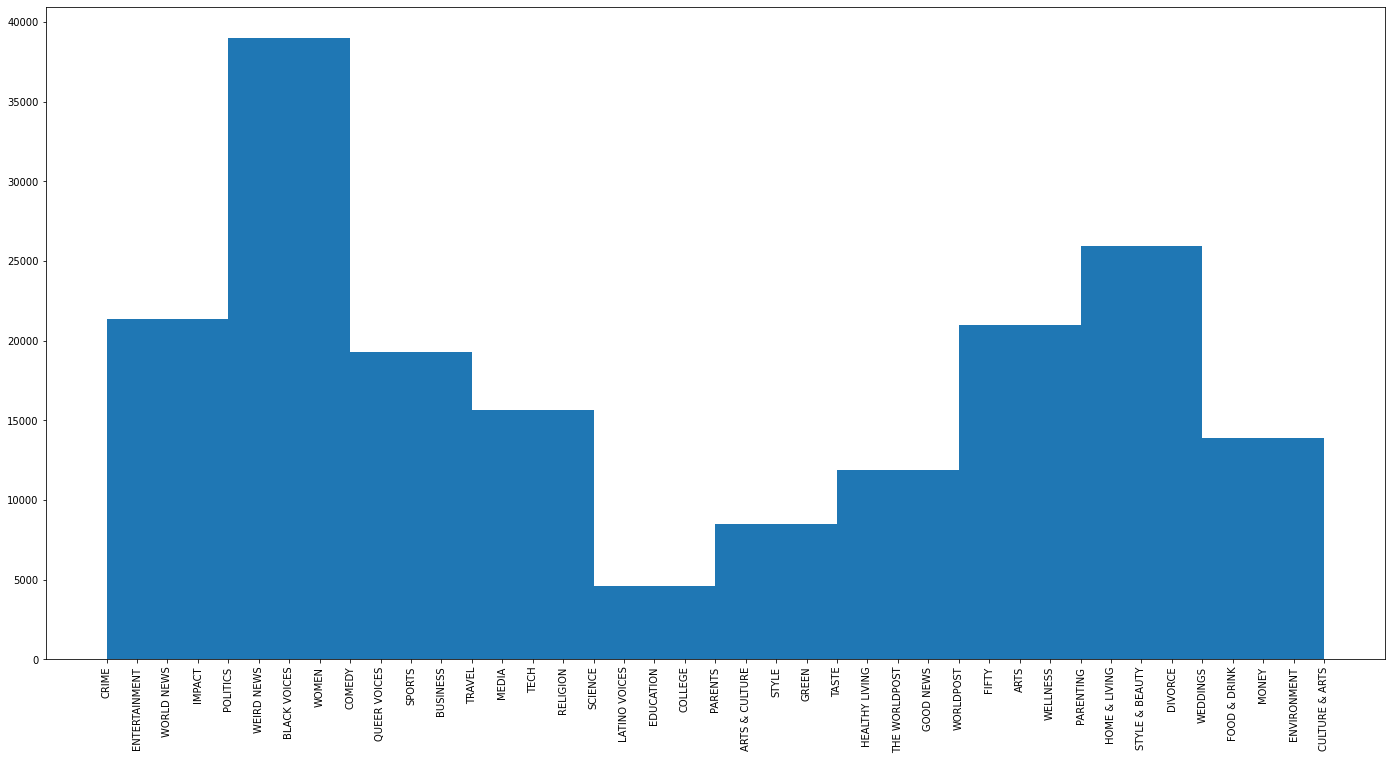

In [25]:
# Show categories distribution
plt.xticks(rotation=90)
plt.hist(df['category'])

In [26]:
# It seams that cleaning worked well
# Start the preprocessing:

# Col(headline, authors) => remove numbers, non-alphapetic chars,
# Col(link) => just keep the url domain and route,  
# Col(short_description) => remove emojies, numbers, non-alphapetic chars  
# Col(authors) => keep the author's name only and remove the title.
# finally lowercase, remove stop-words, and lemmitize all text


# def remove_special_chars(text):
#     re1 = re.compile(r'  +')
#     x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
#         'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
#         '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
#         ' @-@ ', '-').replace('\\', ' \\ ')
#     return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def lemmatize_words(words):
    """Lemmatize words in text"""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]


def lemmatize_verbs(words):
    """Lemmatize verbs in text"""
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])


def text2words(text):
    return word_tokenize(text)


def normalize_text(text):
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = replace_numbers(text)
    text = text.lower()
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)
    return words


def get_cleaned_words(text):
  result = normalize_text(text)
  return text_to_word_sequence(result)

In [27]:
for i in range(20): 
  result = normalize_text(df['short_description'][i])
  print(result)

leave husband kill child another day america
course song
actor longtime girlfriend anna eberstein tie knot civil ceremony
actor give dems asskicking fight hard enough donald trump
dietland actress say use bag really cathartic therapeutic moment
right equate horrific incident sexual assault misplace compliment humor say statement
catchy right
there great miniseries join week
myers kid may push new power film anyone
youre get recent academy awardwinning movie
pop star also wear santa fe strong shirt show houston
two meet pave way summit north korean u
revolution come rural new brunswick
last month health human service official reveal government unable locate nearly child release custody
wiretap feature conversation alexander torshin alexander romanov convict russian money launderer
dont count robert mueller nail nsa whistleblower warn
peep minute
irish woman longer travel unite kingdom end pregnancy
interior secretary attempt damage control hunt fish group didnt like fossil fuel focus
fo

In [28]:
# Preprocess the dataframe
df_clean = df.copy()
df_clean['authors'] = df_clean['authors'].str.split(',', n=1, expand=True).iloc[:, 0]

df_clean.head()

,category,headline,authors,short_description,date
0,CRIME,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV",Melissa Jeltsen,She left her husband. He killed their children. Just another day in America.,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song,Andy McDonald,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork,Ron Dicker,The actor gives Dems an ass-kicking for not fighting hard enough against Donald Trump.,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog,Ron Dicker,"The ""Dietland"" actress said using the bags is a ""really cathartic, therapeutic moment.""",2018-05-26


In [33]:
# combine the 3 str columns into 1.
df_clean['text'] = df_clean['authors'] + ' ' + df_clean['headline'] + ' ' + df_clean['short_description']

df_clean['text'] = df_clean['text'].apply(normalize_text)

df_clean.head()  

,category,headline,authors,short_description,date,text
0,CRIME,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV",Melissa Jeltsen,She left her husband. He killed their children. Just another day in America.,2018-05-26,melissa jeltsen mass shoot texas last week tv leave husband kill child another day america
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song,Andy McDonald,Of course it has a song.,2018-05-26,andy mcdonald smith join diplo nicky jam world cup official song course song
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.,2018-05-26,ron dicker hugh grant marry first time age actor longtime girlfriend anna eberstein tie knot civil ceremony
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork,Ron Dicker,The actor gives Dems an ass-kicking for not fighting hard enough against Donald Trump.,2018-05-26,ron dicker jim carrey blast castrato adam schiff democrat new artwork actor give dems asskicking fight hard enough donald trump
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog,Ron Dicker,"The ""Dietland"" actress said using the bags is a ""really cathartic, therapeutic moment.""",2018-05-26,ron dicker julianna margulies us donald trump poop bag pick dog dietland actress say use bag really cathartic therapeutic moment


## Modelling

In [34]:
y = pd.get_dummies(df_clean['category']).values

print(y.shape)
y

(181127, 41)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [35]:
# split to train, validation sets
from sklearn.model_selection import train_test_split
train, val, y_train, y_val = train_test_split(df_clean, y, test_size=0.20, random_state=42)

print('train.shape =', train.shape)
print('val.shape =', val.shape)
print('y_train.shape =', y_train.shape)
print('y_val.shape =', y_val.shape)

train.shape = (144901, 6)
val.shape = (36226, 6)
y_train.shape = (144901, 41)
y_val.shape = (36226, 41)


(array([4.0884e+04, 6.6596e+04, 1.6305e+04, 1.5177e+04, 5.0390e+03,
        6.3100e+02, 8.4000e+01, 2.7000e+01, 1.3000e+01, 1.4000e+01,
        1.6000e+01, 3.3000e+01, 3.5000e+01, 3.2000e+01, 7.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([  1. ,  13.1,  25.2,  37.3,  49.4,  61.5,  73.6,  85.7,  97.8,
        109.9, 122. , 134.1, 146.2, 158.3, 170.4, 182.5, 194.6, 206.7,
        218.8, 230.9, 243. ]),
 <a list of 20 Patch objects>)

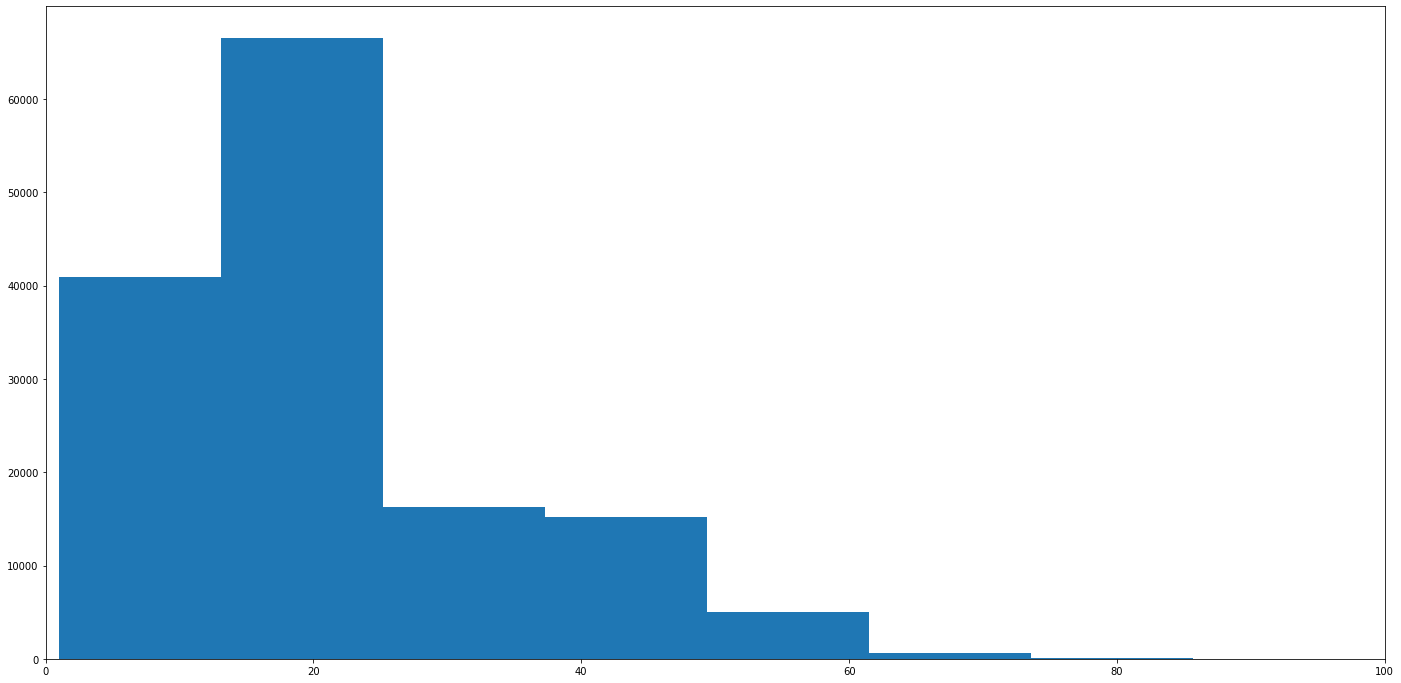

In [37]:
# Try a base model with only the 'short_description' column

# show lengths distribution
plt.xlim([0, 100])
plt.hist([len(text.split(' ')) for text in train['short_description']], bins=20)

In [64]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


MAX_LEN = 64
MAX_WORDS = 10_000

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train['text'])

sequences = tokenizer.texts_to_sequences(train['text'])
val_sequences = tokenizer.texts_to_sequences(val['text'])

print(len(sequences), len(val_sequences))

print(sequences[:10])
print(val_sequences[:10])

144901 36226
[[2, 1510, 1574, 284, 345, 1, 145, 19, 89, 19], [1, 6935, 1630, 68, 31, 23, 1114, 1165, 409, 639, 225, 3057, 37, 96, 161, 37, 3986, 150, 161, 37, 57], [2, 414, 947, 204, 17, 109, 5588, 241, 4778, 1267, 3, 241, 16, 576, 29, 6432, 4584, 947, 2303, 3878, 272, 4129], [377, 1986, 124, 2514, 5850, 5479, 1450, 96, 40, 83, 320, 6491, 342, 1350, 981, 206, 1276, 2959], [2, 1, 118, 719, 168, 118, 4, 35, 794, 1, 498, 199, 483, 230, 267, 8486, 18, 35, 57, 397, 17], [846, 2986, 182, 1226, 169, 183, 2835, 5526, 1, 51, 1218, 1057, 24], [3058, 2366, 1605, 47, 1, 1782, 20, 2253, 105, 154, 736, 26, 126, 336, 8, 323, 347, 64, 253, 2254], [322, 731, 5246, 5643, 8841, 471, 2071, 638, 2760, 5, 1490, 1158, 5643, 645, 320, 2908, 4404], [1035, 1091, 31, 5, 16, 410, 1007, 2079, 4815, 277, 250, 712, 2854, 1900, 4894, 3369, 1609, 5782, 295, 88, 712, 385, 5644], [2, 635, 43, 790, 614, 2737, 532, 14, 1956, 95, 1015, 1523, 1, 256, 14, 1956, 3109, 100, 67]]
[[5180, 1, 6977, 55, 394, 764, 128, 393, 45, 416

In [65]:
padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=MAX_LEN)
padded_val = pad_sequences(val_sequences, padding='post', truncating='post', maxlen=MAX_LEN)

print(padded[0])
print(padded.shape)
print(padded_val.shape)

[   2 1510 1574  284  345    1  145   19   89   19    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
(144901, 64)
(36226, 64)


In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall

EMB_SIZE = 128

model = Sequential([
           Embedding(MAX_WORDS, EMB_SIZE, mask_zero=True, input_length=MAX_LEN),
           LSTM(128),
          #  Dense(128, activation='relu'),
           Dense(41, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'] #[CategoricalAccuracy(), Precision(), Recall()]
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 64, 128)           1280000   
                                                                 
 lstm_6 (LSTM)               (None, 128)               131584    
                                                                 
 dense_6 (Dense)             (None, 41)                5289      
                                                                 
Total params: 1,416,873
Trainable params: 1,416,873
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.fit(
    padded,
    y_train,
    batch_size = 256,
    epochs = 5,
    validation_data = (padded_val, y_val),
    verbose=1,
)

Epoch 1/5
567/567 [==============================] - 295s 513ms/step - loss: 2.0658 - accuracy: 0.4580 - val_loss: 1.4348 - val_accuracy: 0.6212
Epoch 2/5
567/567 [==============================] - 289s 509ms/step - loss: 1.2121 - accuracy: 0.6722 - val_loss: 1.1884 - val_accuracy: 0.6783
Epoch 3/5
567/567 [==============================] - 289s 510ms/step - loss: 0.9906 - accuracy: 0.7241 - val_loss: 1.1011 - val_accuracy: 0.6966
Epoch 4/5
567/567 [==============================] - 288s 508ms/step - loss: 0.8508 - accuracy: 0.7573 - val_loss: 1.0808 - val_accuracy: 0.7031
Epoch 5/5
567/567 [==============================] - 289s 509ms/step - loss: 0.7501 - accuracy: 0.7816 - val_loss: 1.0881 - val_accuracy: 0.7028


## Enhancement

In [ ]:
# Merge 'CULTURE & ARTS' and 'ARTS & CULTURE' may increase accuracy
df[(df['category'] == 'CULTURE & ARTS') | (df['category'] == 'ARTS & CULTURE')].sample(20) # almost the same

,category,headline,authors,short_description,date
45073,ARTS & CULTURE,Paintings Of Feminist Protestors Celebrate The Women Who Bare It All To Fight Back,Priscilla Frank,May Nadine Faraj's watercolors give you life in this month of garbage news.,2016-10-17
72082,ARTS & CULTURE,New Taylor Swift Book To Be Co-Authored By Her Fans,Maddie Crum,Who knew T. Swift would ring in the future of storytelling?,2015-12-14
165085,CULTURE & ARTS,Moving Image: Our Week In Photos (February 9-15),NON_EXIST,"Welcome to ""Moving Image,"" our slideshow of the best photos of the week from around the world. The following photographs",2013-02-16
32150,ARTS & CULTURE,Strangely Compelling 'Shybot' Roams California Desert Avoiding Humans,Mary Papenfuss,The Desert X Biennial art project frees the little rover from us.,2017-03-11
162353,CULTURE & ARTS,"Walter Pierce, Architect Of Modernist Homes, Is Dead At 93",NON_EXIST,"Read more on The New York Times Had Paul Revere made another pass through Lexington, Mass., only this time in the 1940s, he",2013-03-17
167686,CULTURE & ARTS,Contribute to the Unofficial Inaugural Poem,"John Lundberg, Contributor\nWriter, Poetry teacher","Organizers have asked us (!) to harness our most patriotic and poetic instincts (!) with the hashtag #prezpoem. At times, we might come off as a little too earnest, and we might go a little crazy with our adjectives, and we might not even take the time to spell ""thru"" correctly, but don't judge us.",2013-01-20
161676,CULTURE & ARTS,LaToya Ruby Frazier Photographs: 'A Haunted Capital' Captures Family Life In A Forgotten Industrial Town (PHOTOS),NON_EXIST,"""A Haunted Capital"" runs from March 22 - August 11 at the Brooklyn Museum. Scroll through the slideshow below to see some",2013-03-24
131909,CULTURE & ARTS,Kindly Allow This Abstraction Of Google Earth To Blow Your Mind,NON_EXIST,The Color Project at IFP Media Center from MPC Digital on Vimeo. Simultaneously displaying the uniqueness of each place and,2014-02-02
53712,ARTS & CULTURE,Queer Photographer Revisits Traumatic High School Sports Tryouts In Stunning Series,Priscilla Frank,"""I was petrified to remove my shirt in the locker room,"" Ryan Caruthers explained.",2016-07-11
80999,ARTS & CULTURE,Getty Is Quietly Charging Bloggers For 'Socially Awkward Penguin' Meme,Sara Boboltz,One of the Internet's favorite jokes belongs to the photo service.,2015-09-05
